## Data Loading and Formatting

In [1]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2
import itertools

# This will be useful so we can construct the corresponding mask
def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

# Create image generator and preform preprocessing
def image_gen(img_paths, mask_paths=[], img_size=(384, 384), train=True):
    # Iterate over all the image paths
    for img_path, mask_path in itertools.zip_longest(img_paths, mask_paths):
        
        # Load image and sharpen
        img = imread(img_path)
        img = resize(img, img_size)
        # Normalize it to 0-1 range
#         img = img / 255.0.  
        ##############################
        
        # Get mask information for train data
        if train:
            mask = rgb2gray(imread(mask_path))
            # Turn the mask back into a 0-1 mask
            mask = (mask >= 0.5).astype(float)
            
            # Yield the image mask pair
            yield img, mask
            
        else:
            yield img

## Metric Definitions

In [2]:
import keras.backend.tensorflow_backend as K
from keras.losses import binary_crossentropy

smooth = 1e-9

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

Using TensorFlow backend.


In [3]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
from keras.optimizers import Adam

## Model Definition
###### Note: Max pooling replaced with convolutions

In [30]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint

# IMG_SIZE = (512, 512)
IMG_SIZE = (384, 384)

# Build U-Net model
inputs = Input(IMG_SIZE+(3,))
s = BatchNormalization()(inputs) # we can learn the normalization step
s = Dropout(0.5)(s)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = Conv2D(8, kernel_size=(1,1), strides=(2,2), activation='relu', padding='same') (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = Conv2D(16, kernel_size=(1,1), strides=(2,2), activation='relu', padding='same') (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = Conv2D(32, kernel_size=(1,1), strides=(2,2), activation='relu', padding='same') (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = Conv2D(64, kernel_size=(1,1), strides=(2,2), activation='relu', padding='same') (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])
model.summary()

# Checkpoint the best model across all training epochs based on validation dice coefficient
filepath = "DepooledUNet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_dice_coef', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]# checkpoint

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 384, 384, 3)  12          input_17[0][0]                   
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 384, 384, 3)  0           batch_normalization_17[0][0]     
__________________________________________________________________________________________________
conv2d_206 (Conv2D)             (None, 384, 384, 8)  224         dropout_17[0][0]                 
__________________________________________________________________________________________________
conv2d_207

## Batch generator function

In [31]:
import numpy as np

# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, mask_paths, batchsize=32):
    while True:
        ig = image_gen(img_paths, mask_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            batch_img.append(img)
            mask = resize(mask, (384, 384, 1)) # Reshape masks to be (512, 512, 1)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
            batch_img, batch_mask = [], []
            
            
def test_batch_generator(img_paths, batchsize=32):
    while True:
        ig = image_gen(img_paths, train=False)
        batch_img = []
        
        for img in ig:
            # Add the image and mask to the batch
            batch_img.append(img)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0)
                batch_img = []
        
        # If we have an nonempty batch left, yield it out and reset
        if len(batch_img) != 0:
            yield np.stack(batch_img, axis=0)
            batch_img = []

## Train Model

In [21]:
def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

In [23]:
import os
import multiprocessing
from glob import glob
from keras.preprocessing.image import ImageDataGenerator

BATCHSIZE = 50
num_cores = multiprocessing.cpu_count()

# construct the training image generator for data augmentation
aug = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15,
                         width_shift_range=0.2, height_shift_range=0.2, 
                         shear_range=0.15, horizontal_flip=True, fill_mode="nearest")
 
seed = 1

image_generator = aug.flow_from_directory(
    'data/train_images',
    target_size=(384, 384),
    color_mode='rgb',
    class_mode=None,
    batch_size=BATCHSIZE,
    seed=seed)

mask_generator = aug.flow_from_directory(
    'data/train_masks',
    target_size=(384, 384),
    color_mode='grayscale',
    class_mode=None,
    batch_size=BATCHSIZE,
    seed=seed)

# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)

Found 7627 images belonging to 1 classes.
Found 7627 images belonging to 1 classes.


In [26]:
path_to_train = 'data/train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = sorted(glob(glob_train_imgs))
train_mask_paths = sorted(glob(glob_train_masks))

path_to_val = 'data/val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
glob_val_masks = os.path.join(path_to_val, '*_msk.png')

val_img_paths = sorted(glob(glob_val_imgs))
val_mask_paths = sorted(glob(glob_val_masks))

In [28]:
# Create image batch generators for training and validation
traingen = image_batch_generator(train_img_paths, train_mask_paths, batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths, val_mask_paths, batchsize=BATCHSIZE)

In [33]:
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

# Train the model
history = model.fit_generator(
#     Data augmentation
    train_generator, 
    steps_per_epoch=train_steps * 3, 
#     traingen,
#     steps_per_epoch=train_steps,
    epochs=40,
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    callbacks = callbacks_list,
    max_queue_size=5  # Change this number based on memory restrictions
)

Epoch 1/40
459/459 [==============================] - 1323s 3s/step - loss: 0.9352 - dice_coef: 0.1392 - val_loss: 0.8817 - val_dice_coef: 0.2721

Epoch 00001: val_dice_coef improved from -inf to 0.27209, saving model to DepooledUNet.hdf5
Epoch 2/40
459/459 [==============================] - 1271s 3s/step - loss: 0.7756 - dice_coef: 0.3355 - val_loss: 0.6416 - val_dice_coef: 0.4569

Epoch 00002: val_dice_coef improved from 0.27209 to 0.45689, saving model to DepooledUNet.hdf5
Epoch 3/40
459/459 [==============================] - 1261s 3s/step - loss: 0.6570 - dice_coef: 0.4425 - val_loss: 0.5797 - val_dice_coef: 0.5183

Epoch 00003: val_dice_coef improved from 0.45689 to 0.51826, saving model to DepooledUNet.hdf5
Epoch 4/40
459/459 [==============================] - 1289s 3s/step - loss: 0.6026 - dice_coef: 0.4900 - val_loss: 0.5822 - val_dice_coef: 0.5211

Epoch 00004: val_dice_coef improved from 0.51826 to 0.52108, saving model to DepooledUNet.hdf5
Epoch 5/40
459/459 [===============

459/459 [==============================] - 1285s 3s/step - loss: 0.4252 - dice_coef: 0.6421 - val_loss: 0.4958 - val_dice_coef: 0.5846

Epoch 00039: val_dice_coef did not improve from 0.64011
Epoch 40/40
459/459 [==============================] - 1289s 3s/step - loss: 0.4242 - dice_coef: 0.6429 - val_loss: 0.5402 - val_dice_coef: 0.5472

Epoch 00040: val_dice_coef did not improve from 0.64011


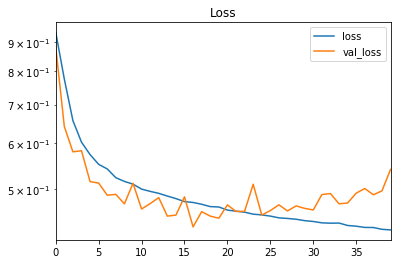

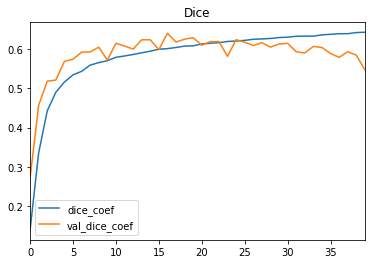

In [35]:
import pandas as pd

# Plot the training curve
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(title="Loss", logy=True)
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot(title="Dice")